# CATS AND DOGS CLASSIFICATION USING KERAS

References:

https://www.youtube.com/watch?v=qFJeN9V1ZsI&t=6036s
https://github.com/thepghimire/LearningKeras/blob/master/Image%20preparation%20for%20CNN%20using%20Keras.ipynb (Modified)

CNN 3D Visualization : https://www.youtube.com/watch?v=f0t-OCG79-U

Another Sweet Video : https://www.youtube.com/watch?v=3JQ3hYko51Y

How convolutional neural networks see the world:
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

## Imports

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Setup

in current directory, images are present in data/cats-and-dogs

In [25]:
# os.chdir("../../")
print("Current directory = "+os.getcwd())

Current directory = C:\Users\anandhukrishnan.v\OneDrive - EY\Desktop\Documents\My_HobbyProjects\DeepLizard\Keras-Machine-Learning-Deep-Learning-Tutorial


In [26]:
# Train, Validation and test sets:
os.chdir('data/cats-and-dogs')
print("Current directory = "+os.getcwd())
if os.path.isdir('train/dog') is False:
    
    print("Creating directories")
    
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    print("Copying Files...")
    
    for c in random.sample(glob.glob('cat*'), 50):   # glob function finds the files matching the pattern given in bracket
        shutil.copy(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.copy(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 10):
        shutil.copy(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 10):
        shutil.copy(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 5):
        shutil.copy(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 5):
        shutil.copy(c, 'test/dog')
        
    print("Done copying Files...")

os.chdir("../../")    
print("Back to directory = "+os.getcwd())

Current directory = C:\Users\anandhukrishnan.v\OneDrive - EY\Desktop\Documents\My_HobbyProjects\DeepLizard\Keras-Machine-Learning-Deep-Learning-Tutorial\data\cats-and-dogs
Back to directory = C:\Users\anandhukrishnan.v\OneDrive - EY\Desktop\Documents\My_HobbyProjects\DeepLizard\Keras-Machine-Learning-Deep-Learning-Tutorial


## Prepare train,validation and test sets

In [27]:
train_path = 'data/cats-and-dogs/train'
valid_path = 'data/cats-and-dogs/valid'
test_path = 'data/cats-and-dogs/test'

In [55]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches  = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path,  target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)
# Why are we doing preprocessing using a preprocessing_function? Need to understand this - WATCH 1:41:15 of Mandy

Found 100 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [29]:
assert train_batches.n == 100
assert valid_batches.n == 20
assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

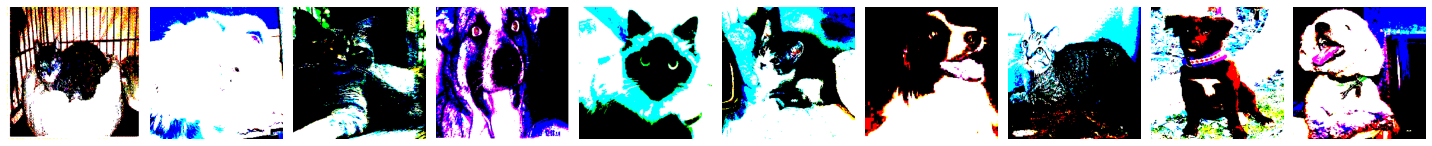

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [30]:
# plot images in grid form with 1 row, 10 columns where images are placed 
# This function is directly from tensoflow website
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = next(train_batches) #The next() function returns the next item in an iterator.
plotImages(imgs)
print(labels)

## Build the CNN Model

In [56]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2),strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2),strides=2),
        Flatten(), #Convert data into a 1-dimensional. We flatten the output of the convolutional layers to create a single long feature vector that is fed to next layer
        Dense(2, activation='softmax'),
    ])


model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#NOTES

# Mandy has created an awesome tool to visualize convolution https://deeplizard.com/resource/pavq7noze2

#kernal_size : this is how we can set filter size 3*3 in keras
#padding=same means, pad 0's to the edge of input so that the layer outputs the same input size (see the ouput size of layer in summary)
#padding=valid means no padding(default even if we didnt specify)
#max pool - same as filter, here call it pool (2*2 grid), moves in steps of 2 pixes (srtides) to get the max values of that 2*2 grid
#2*2 with stride 2 will make size half!(see output shape in summary)
# why needed ? 
# https://www.youtube.com/watch?v=ZjM_XQa5s6s&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=22
#     6:9


#softmax function -The softmax function is a function that turns a vector of K real values into a vector of K real values
# that sum to 1. The input values can be positive, negative, zero, or greater than one, 
# but the softmax transforms them into values between 0 and 1, so that they can be interpreted as probabilities.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

## TRAIN!

In [32]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

# wer are not specifying y bcz we store data as generator (guess the same for batch size also)

Epoch 1/10
10/10 - 7s - loss: 49.5253 - accuracy: 0.5000 - val_loss: 33.3022 - val_accuracy: 0.5000
Epoch 2/10
10/10 - 6s - loss: 11.0894 - accuracy: 0.6800 - val_loss: 12.8884 - val_accuracy: 0.5500
Epoch 3/10
10/10 - 5s - loss: 3.6357 - accuracy: 0.8200 - val_loss: 9.1604 - val_accuracy: 0.6000
Epoch 4/10
10/10 - 5s - loss: 2.3376 - accuracy: 0.8300 - val_loss: 10.3272 - val_accuracy: 0.6500
Epoch 5/10
10/10 - 5s - loss: 3.2953 - accuracy: 0.8600 - val_loss: 8.5639 - val_accuracy: 0.6000
Epoch 6/10
10/10 - 5s - loss: 0.8650 - accuracy: 0.9600 - val_loss: 19.8688 - val_accuracy: 0.5500
Epoch 7/10
10/10 - 5s - loss: 0.3386 - accuracy: 0.9800 - val_loss: 7.3690 - val_accuracy: 0.6000
Epoch 8/10
10/10 - 6s - loss: 0.9696 - accuracy: 0.9600 - val_loss: 7.4566 - val_accuracy: 0.6500
Epoch 9/10
10/10 - 5s - loss: 0.3660 - accuracy: 0.9400 - val_loss: 12.4153 - val_accuracy: 0.6500
Epoch 10/10
10/10 - 5s - loss: 0.1003 - accuracy: 0.9900 - val_loss: 6.5852 - val_accuracy: 0.6500


# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

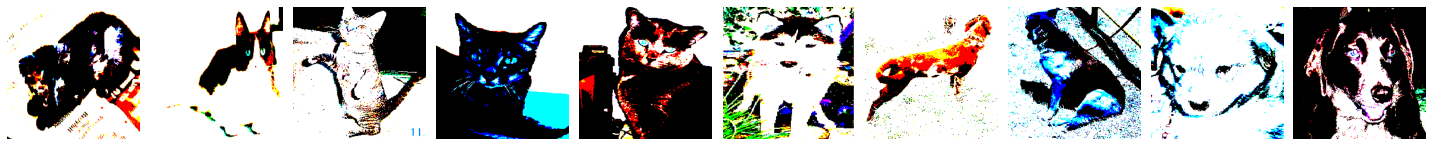

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [33]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [34]:
print(test_batches.classes)

[0 0 0 0 0 1 1 1 1 1]


In [35]:
predictions = model.predict(test_batches, verbose=0)

In [36]:
print(predictions.shape)
print(predictions) #

(10, 2)
[[9.9998307e-01 1.6901336e-05]
 [1.0000000e+00 2.0168903e-38]
 [1.0000000e+00 1.5845588e-19]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.6189820e-17]
 [1.0000000e+00 2.9394498e-26]
 [1.0000000e+00 3.4214308e-11]
 [9.9999976e-01 1.8385923e-07]
 [1.0000000e+00 9.6138643e-23]
 [1.0000000e+00 5.8277468e-15]]


In [37]:
print(np.round(predictions))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## Confusion Matrix

In [38]:
#Expected and Actual (printed so i can just check if my confusion matrix is correct)
print(predictions.shape)
print(test_batches.classes)
print(np.argmax(predictions,axis=-1)) #Argmex -1 : https://stackoverflow.com/questions/47435526/what-is-the-meaning-of-axis-1-in-keras-argmax



#Pass them to confusion matrix
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

(10, 2)
[0 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0]


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[4 1]
 [2 3]]


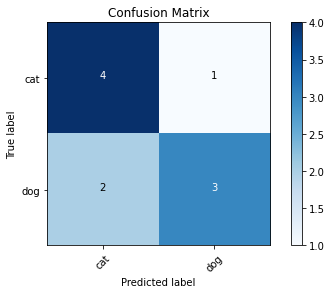

In [67]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

###### Our above model obviously overfits.. damn!

# CATS AND DOGS CLASSIFICATION USING KERAS - FINE TUNE EXISTING MODEL VGG16
This model is already trained with data 'including cats and dogs' , later we will do with completely new data

## Import model

In [44]:
vgg16_model = tf.keras.applications.vgg16.VGG16() # Will download the entire model on first run (above 500MB)
vgg16_model.summary()
type(vgg16_model) # Displays the type of model. This is not sequential model(Earlier we did Sequential Models)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

tensorflow.python.keras.engine.functional.Functional

## Convert it into Sequential Model

In [45]:
## Loop through evey layer except last one and add it to our sequential model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

# Guess otherwise we can use model.layers.pop() to remove one layer(need to confirm)    

In [46]:
model.summary()   # Compare the summaries(this wont have last layer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [47]:
#Freeze the layers to prevent them changing
for layer in model.layers:
    layer.trainable = False

In [48]:
model.add(Dense(2, activation='softmax'))

In [49]:
model.summary() #Check the new layer and also trainable params count

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Train the fine-tuned VGG16 model

In [50]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=5, verbose=2)

#After training, check the validation accuracty.. It is far better that of the sequestion model we built on our own (That one was overfitting)

Epoch 1/5
10/10 - 32s - loss: 0.5984 - accuracy: 0.6900 - val_loss: 0.2832 - val_accuracy: 0.8500
Epoch 2/5
10/10 - 32s - loss: 0.3145 - accuracy: 0.8500 - val_loss: 0.1427 - val_accuracy: 0.9500
Epoch 3/5
10/10 - 32s - loss: 0.1803 - accuracy: 0.9800 - val_loss: 0.0957 - val_accuracy: 1.0000
Epoch 4/5
10/10 - 34s - loss: 0.1233 - accuracy: 0.9700 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 5/5
10/10 - 31s - loss: 0.0934 - accuracy: 0.9700 - val_loss: 0.0571 - val_accuracy: 1.0000


## Predict using fine-tuned VGG16 model

In [52]:
predictions = model.predict(x=test_batches,verbose=0)

In [53]:
print(test_batches.classes)
print(predictions)
print(np.argmax(predictions,axis=-1))
test_batches.class_indices

#Pass them to confusion matrix
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

[0 0 0 0 0 1 1 1 1 1]
[[9.71006870e-01 2.89931111e-02]
 [9.99108016e-01 8.91981297e-04]
 [9.88662660e-01 1.13373101e-02]
 [9.99735653e-01 2.64361559e-04]
 [9.97719467e-01 2.28046579e-03]
 [1.53053656e-01 8.46946359e-01]
 [1.44131165e-02 9.85586882e-01]
 [7.76131451e-02 9.22386825e-01]
 [1.36733586e-02 9.86326575e-01]
 [1.57451127e-02 9.84254956e-01]]
[0 0 0 0 0 1 1 1 1 1]


Confusion matrix, without normalization
[[5 0]
 [0 5]]


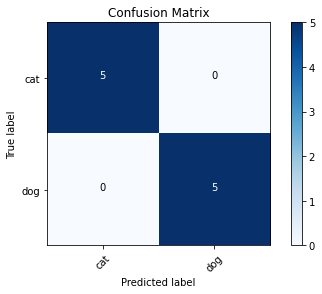

In [54]:
plot_confusion_matrix(cm, ['cat','dog'], title='Confusion Matrix')

### REVIEWED ON 24th August ---------------